# IMDB project: predicting genres out of movie plots
### by Javier Alonso

This Jupyter Notebook is part of "My IMDB project", and we tries to predict the genre of a movie out of its plot

This database is different than the one used in the rest of the project, as the database downloaded directly from IMDB didn´t include the plot. I took this database from [Kaggle](https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset) that a user web scrapped from the web. All the movies with more than 100 votes have been scraped as of 17/11/2019

All "My IMDB project is published in my [blog](https://javieralonsoalonso.com/category/my-imdb-project/)

## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
1.c.-[Consolidation of Dataframes](#Consolidaion_dataframes)<br>
2. [Machine Learning algorithm](#ML)<br>
2.a.-[Model Selection with all genres](#Model_all)<br>
2.b.-[Logistic regression with all the genres](#LogR_All)<br>
2.c.-[Logistic regression with top 5 genres](#LogR_top5)<br>
2.d.-[Logistic regression with balance dataframe](#LogR_Bal)<br>
2.e.-[Logistic regression for Drama and Comedy changing number of movies](#LogR_D_C)<br>


## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling

In [2]:
# Import useful packages, modules, classes, and functions:
from __future__ import print_function

# ## Create a SparkSession

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("yarn").appName("predictinggenre").getOrCreate()

from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import count, countDistinct
import pyspark.sql.functions as f
from pyspark.sql.functions import col, round
from pyspark.sql.functions import explode
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from nltk.stem.porter import PorterStemmer
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.feature import Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.sql.functions import split
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [2]:
# Get the configuration of the spark session
spark.sparkContext.getConf().getAll()

[(u'spark.eventLog.enabled', u'true'),
 (u'spark.dynamicAllocation.minExecutors', u'1'),
 (u'spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  u'cluster-b9da-m'),
 (u'spark.history.fs.logDirectory',
  u'hdfs://cluster-b9da-m/user/spark/eventlog'),
 (u'spark.yarn.am.memory', u'640m'),
 (u'spark.eventLog.dir', u'hdfs://cluster-b9da-m/user/spark/eventlog'),
 (u'spark.driver.port', u'38773'),
 (u'spark.executor.memory', u'5586m'),
 (u'spark.executor.instances', u'2'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.executorEnv.PYTHONPATH',
  u'/usr/lib/spark/python/lib/py4j-0.10.7-src.zip:/usr/lib/spark/python/:<CPS>{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.7-src.zip'),
 (u'spark.ui.proxyBase', u'/proxy/application_1592641758855_0012'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.app.name', u'predictinggenre'),
 (u'spark.ui.filters',
  u'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 (u'spark.yarn.historyServer.addres

### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In this section we´ll gather data from the csv file, already uploaded to Google Cloud

In [4]:
movies = spark.read.csv("gs://imdbgenres/Predicting_Genres/IMDb movies.csv", header=True, inferSchema=True)

In [5]:
movies.printSchema()

root
 |-- imdb_title_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- date_published: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- language: string (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- production_company: string (nullable = true)
 |-- actors: string (nullable = true)
 |-- description: string (nullable = true)
 |-- avg_vote: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- usa_gross_income: string (nullable = true)
 |-- worlwide_gross_income: string (nullable = true)
 |-- metascore: string (nullable = true)
 |-- reviews_from_users: string (nullable = true)
 |-- reviews_from_critics: string (nullable = true)



In [8]:
movies.count()

81273

In [9]:
movies.show(2)

+-------------+--------------------+--------------------+----+--------------+--------------------+--------+----------------+--------+------------+--------------------+------------------+--------------------+--------------------+--------+-----+------+----------------+---------------------+---------+------------------+--------------------+
|imdb_title_id|               title|      original_title|year|date_published|               genre|duration|         country|language|    director|              writer|production_company|              actors|         description|avg_vote|votes|budget|usa_gross_income|worlwide_gross_income|metascore|reviews_from_users|reviews_from_critics|
+-------------+--------------------+--------------------+----+--------------+--------------------+--------+----------------+--------+------------+--------------------+------------------+--------------------+--------------------+--------+-----+------+----------------+---------------------+---------+------------------+--

### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data

Now, we´re going to assess the dataframe visually and programmatically for quality and tidiness issues, and do the cleaning of these issues

**Keeping only the needed columns**

In [10]:
movies_df = movies.select("imdb_title_id",'title', 'description','genre')

In [11]:
movies_df.printSchema()

root
 |-- imdb_title_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- genre: string (nullable = true)



** Viewing Plot column**

In [12]:
movies_df.select("description").show(5,False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|description                                                                                                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|True story of notorious Australian outlaw Ned Kelly (1855-80).                                                                                                                                  |
|Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home, ...|
|The fabled queen of Egyp

**Duplicates**

We can see there are not duplicates

In [13]:
movies_df.select(count("*"), count("imdb_title_id"), countDistinct("imdb_title_id")).show()

+--------+--------------------+-----------------------------+
|count(1)|count(imdb_title_id)|count(DISTINCT imdb_title_id)|
+--------+--------------------+-----------------------------+
|   81273|               81273|                        81273|
+--------+--------------------+-----------------------------+



**Looking for null values**

In [14]:
# Count the number of missing (null) values in description
movies_df.filter(movies_df.description.isNull()).count()

2430

In [15]:
# Count the number of missing (null) values:
movies_df.filter(movies_df.genre.isNull()).count()

0

In [16]:
#delete the rows with null values
movies_df = movies_df.na.drop()

In [17]:
movies_df.select(count("*"), count("imdb_title_id"), countDistinct("imdb_title_id")).show()

+--------+--------------------+-----------------------------+
|count(1)|count(imdb_title_id)|count(DISTINCT imdb_title_id)|
+--------+--------------------+-----------------------------+
|   78843|               78843|                        78843|
+--------+--------------------+-----------------------------+



**Getting the first genre**

We have movies with more than one genre but Pyspark doens´t support multilabel classification. We have two options:

- We generate n classification algorithms, one per each genre
- We keep just the first genre of those listed and do the classification with it

We are going to get the second option.

In [18]:
movies_df.show()

+-------------+--------------------+--------------------+--------------------+
|imdb_title_id|               title|         description|               genre|
+-------------+--------------------+--------------------+--------------------+
|    tt0000574|The Story of the ...|True story of not...|Biography, Crime,...|
|    tt0001892|      Den sorte drøm|Two men of high r...|               Drama|
|    tt0002101|           Cleopatra|The fabled queen ...|      Drama, History|
|    tt0002130|           L'Inferno|Loosely adapted f...|Adventure, Drama,...|
|    tt0002199|From the Manger t...|An account of the...|    Biography, Drama|
|    tt0002423|      Madame DuBarry|The story of Mada...|Biography, Drama,...|
|    tt0002445|          Quo Vadis?|"An epic Italian ...|      Drama, History|
|    tt0002452|Independenta Roma...|The movie depicts...|        History, War|
|    tt0002461|         Richard III|Richard of Glouce...|               Drama|
|    tt0002646|            Atlantis|After Dr. Friedr

In [19]:
movies_df = movies_df.withColumn("genre_0", f.split(movies_df.genre,", ").getItem(0))

**Counting movies per genre**

Let´s see how many movies exist per genre

In [20]:
movies_df.groupby("genre_0").count().toPandas().sort_values(by = 'count', ascending = False).head(30)

,genre_0,count
4,Drama,23197
19,Comedy,21965
20,Action,11228
0,Crime,5156
16,Horror,4873
3,Adventure,3307
18,Biography,1955
13,Animation,1938
2,Thriller,1256
1,Romance,707


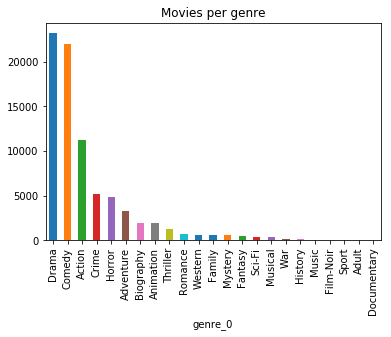

In [22]:
movies_df.groupby("genre_0").count().toPandas().sort_values(by = 'count', ascending = False).plot(x="genre_0", y="count", kind="bar", title ='Movies per genre',legend= False);

In [23]:
movies_df.count()

78843

**Engineering plot column**

The plot column ("description") is a text describing the argument of the movie. We have to treat this text so the algorithm can "understand" it.

- We divide the plot in words tokenizing it

In [30]:
tokenizer = RegexTokenizer(inputCol="description", outputCol="words", gaps=False, pattern="[a-zA-Z-']+")
tokenized = tokenizer.transform(movies_df)

- We remove stop words

In [31]:
remover = StopWordsRemover(inputCol="words", outputCol="relevant_words")
remover.getStopWords()[:10]
removed = remover.transform(tokenized)

- We stem the words to get the root of each word

In [32]:
stemmer = PorterStemmer()
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
stemmed_df = removed.withColumn("words_stemmed", stemmer_udf("relevant_words"))

In [33]:
columns_to_drop = ['words', 'relevant_words']
stemmed_df = stemmed_df.drop(*columns_to_drop)

In [34]:
stemmed_df.printSchema()

root
 |-- imdb_title_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_0: string (nullable = true)
 |-- words_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [35]:
stemmed_df.show(2)

+-------------+--------------------+--------------------+--------------------+---------+--------------------+
|imdb_title_id|               title|         description|               genre|  genre_0|       words_stemmed|
+-------------+--------------------+--------------------+--------------------+---------+--------------------+
|    tt0000574|The Story of the ...|True story of not...|Biography, Crime,...|Biography|[true, stori, not...|
|    tt0001892|      Den sorte drøm|Two men of high r...|               Drama|    Drama|[two, men, high, ...|
+-------------+--------------------+--------------------+--------------------+---------+--------------------+
only showing top 2 rows



- We get the word cloud and a table with most popular words

In [36]:
# Define a function to plot a word cloud:
def plot_word_cloud(df, col):
  # Compute the word count:
  from pyspark.sql.functions import explode
  word_count = df.select(explode(col).alias("word")).groupBy("word").count().collect()
  # Generate the word cloud image:
  from wordcloud import WordCloud
  wordcloud = WordCloud(random_state=12345).fit_words(dict(word_count))
  # Display the word cloud image:
  import matplotlib.pyplot as plt
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")

Remember the stemmed words sometimes don´t exist, as stemming keeps the root but it may be not a word

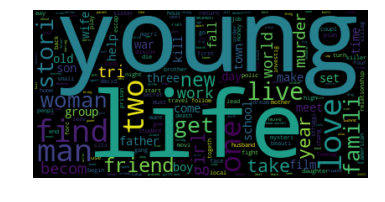

In [37]:
plot_word_cloud(stemmed_df, "words_stemmed")

In [38]:
stemmed_df.select(explode(stemmed_df.words_stemmed).alias("word")).groupBy("word").count().sort("count", ascending = False).show()

+------+-----+
|  word|count|
+------+-----+
| young| 9753|
|  life| 7602|
|  find| 7206|
|  love| 7136|
|   man| 7082|
|   two| 6637|
|   one| 6391|
|  live| 6340|
| stori| 5876|
|   get| 5797|
|famili| 5543|
| woman| 5528|
|friend| 5458|
|   new| 4886|
|  girl| 4667|
|  year| 4591|
|  take| 4577|
| becom| 4302|
|   tri| 4145|
|murder| 3986|
+------+-----+
only showing top 20 rows



- Word2Vec features transformation

The Word2VecModel transforms each document into a vector using the average of all words in the document.

We fix the size of the vector. Usually the number chosen is between 100 and 300. We´ve tried with 200 and 300 and had the same results, so we leave the value in 200

In [40]:
w2v = Word2Vec(vectorSize=200, minCount=0, inputCol="words_stemmed", outputCol="features")
model = w2v.fit(stemmed_df)
plots_df = model.transform(stemmed_df)

In [41]:
plots_df.printSchema()

root
 |-- imdb_title_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_0: string (nullable = true)
 |-- words_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



### <a class="anchor" id="Consolidaion_dataframes"> 1.c.- Consolidation of dataframes

In this section we´re going to consolidate the dataframe into a parquet file, that we´ll be able to read for the next sections

In [43]:
plots_df.write.parquet("gs://imdbgenres/Predicting_Genres/movies_saved")

In [88]:
movies_ml = spark.read.parquet("gs://imdbgenres/Predicting_Genres/movies_saved")

In [89]:
movies_ml.printSchema()

root
 |-- imdb_title_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_0: string (nullable = true)
 |-- words_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



In [90]:
movies_ml.count()

78843

### <a class="anchor" id="ML">2. Machine Learning algorithm

This machine learning algorithm takes features vector as input and classifies data according to genre_0 column

In [91]:
movies_ml.groupby("genre_0").count().toPandas().sort_values(by = 'count', ascending = False).head(30)

,genre_0,count
4,Drama,23197
19,Comedy,21965
20,Action,11228
0,Crime,5156
16,Horror,4873
3,Adventure,3307
18,Biography,1955
13,Animation,1938
2,Thriller,1256
1,Romance,707


In [92]:
clean = movies_ml

In [93]:
clean.printSchema()

root
 |-- imdb_title_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_0: string (nullable = true)
 |-- words_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



### <a class="anchor" id="Model_all"> 2.a.- Model Selection with all genres
    
We are going to test three classification algorithms with the default parameters to see which one fits best our case

In [94]:
final = clean.select("genre_0","features" )

In [95]:
final.show()

+---------+--------------------+
|  genre_0|            features|
+---------+--------------------+
|Biography|[0.01112327832379...|
|    Drama|[0.00206490375594...|
|    Drama|[0.02040101664606...|
|Adventure|[0.04703705926316...|
|Biography|[-0.0080862366799...|
|Biography|[0.01666456178645...|
|    Drama|[0.06428615966190...|
|  History|[0.12395447865128...|
|    Drama|[0.00127093913033...|
|    Drama|[0.00953373475931...|
|    Crime|[-0.0231478297464...|
|    Drama|[0.06226695703558...|
|    Crime|[-4.2601116464621...|
|    Drama|[-0.0155917519005...|
|    Crime|[-0.0178669797870...|
|    Drama|[0.01824441807444...|
|    Drama|[0.03153087164537...|
|    Crime|[-0.0464643247791...|
|Adventure|[-0.0400727293939...|
|    Drama|[0.00423835639958...|
+---------+--------------------+
only showing top 20 rows



In [96]:
final.printSchema()

root
 |-- genre_0: string (nullable = true)
 |-- features: vector (nullable = true)



In [97]:
# Divide dataframe in train and test
train_df, test_df = final.randomSplit([0.8, 0.2])

In [98]:
# Converts the genre, in text, to a number
si = StringIndexer(inputCol="genre_0", outputCol="label")

In [99]:
# Create the results dataframe
from pyspark.sql.types import *

field = [StructField('Algorithm',StringType()),StructField('Train_Accuracy', IntegerType()),\
 StructField('Train_F1', IntegerType()), StructField('Test_Accuracy', IntegerType()),  StructField('Test_F1', IntegerType())]


schema = StructType(field)
models_score = sqlContext.createDataFrame(sc.emptyRDD(), schema)

**Decision Tree**

In [100]:
classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")

classifier_pipeline = Pipeline(stages=[si,classifier])
model = classifier_pipeline.fit(train_df)
pred_train = model.transform(train_df)
pred_test = model.transform(test_df)

model_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

model_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

acc_train = model_acc.evaluate(pred_train)
acc_test = model_acc.evaluate(pred_test)
f1_train = model_f1.evaluate(pred_train)
f1_test = model_f1.evaluate(pred_test)

newRow = spark.createDataFrame([('Decision Tree', acc_train, f1_train, acc_test, f1_test)])
models_score = models_score.union(newRow)

**Random Forest**

In [101]:
classifier = RandomForestClassifier(labelCol="label", featuresCol="features")

classifier_pipeline = Pipeline(stages=[si,classifier])
model = classifier_pipeline.fit(train_df)
pred_train = model.transform(train_df)
pred_test = model.transform(test_df)

model_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

model_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

acc_train = model_acc.evaluate(pred_train)
acc_test = model_acc.evaluate(pred_test)
f1_train = model_f1.evaluate(pred_train)
f1_test = model_f1.evaluate(pred_test)

newRow = spark.createDataFrame([('Random Forest', acc_train, f1_train, acc_test, f1_test)])
models_score = models_score.union(newRow)

**LogisticRegression Model**

In [102]:
classifier = LogisticRegression(family="multinomial")

classifier_pipeline = Pipeline(stages=[si,classifier])

model = classifier_pipeline.fit(train_df)

pred_train = model.transform(train_df)
pred_test = model.transform(test_df)

model_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

model_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

acc_train = model_acc.evaluate(pred_train)
acc_test = model_acc.evaluate(pred_test)
f1_train = model_f1.evaluate(pred_train)
f1_test = model_f1.evaluate(pred_test)

newRow = spark.createDataFrame([('Logistic Regression', acc_train, f1_train, acc_test, f1_test)])
models_score = models_score.union(newRow)

**Results**

In [104]:
models_score.select("Algorithm", f.round("Train_Accuracy",3).alias("Train_Accuracy"), \
                    f.round("Train_F1",3).alias("Train_F1"), \
                    f.round("Test_Accuracy",3).alias("Test_Accuracy"), \
                    f.round("Test_F1",3).alias("Test_F1"), \
                   ).toPandas().head(5)

,Algorithm,Train_Accuracy,Train_F1,Test_Accuracy,Test_F1
0,Decision Tree,0.398,0.355,0.390,0.350
1,Random Forest,0.423,0.362,0.419,0.359
2,Logistic Regression,0.458,0.425,0.456,0.424


We see that Logistic regression is the best algorithm with the default parameters.

The results are poor, but we are going to check why.

It surprises me that Decision Tree, almost always overfitted, here doesn´t overfit too much

### <a class="anchor" id="LogR_All"> 2.b.- Logistic regression with all the genres

I´m going to dig into the case of Logistic regression with all the data

In [31]:
final = clean.select("genre_0","features" )

In [34]:
final.printSchema()

root
 |-- genre_0: string (nullable = true)
 |-- features: vector (nullable = true)



In [35]:
final.groupby("genre_0").count().toPandas().sort_values(by = 'count', ascending = False).head(30)

,genre_0,count
4,Drama,23197
19,Comedy,21965
20,Action,11228
0,Crime,5156
16,Horror,4873
3,Adventure,3307
18,Biography,1955
13,Animation,1938
2,Thriller,1256
1,Romance,707


In [36]:
train_df, test_df = final.randomSplit([0.8, 0.2])

In [40]:
classifier = LogisticRegression(family="multinomial")

classifier_pipeline = Pipeline(stages=[si,classifier])

model = classifier_pipeline.fit(train_df)

pred_train = model.transform(train_df)
pred_test = model.transform(test_df)

model_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

model_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

acc_train = model_acc.evaluate(pred_train)
acc_test = model_acc.evaluate(pred_test)
f1_train = model_f1.evaluate(pred_train)
f1_test = model_f1.evaluate(pred_test)

In [41]:
print("Logistic Regression Accuracy train = %g" % (acc_train))
print("Logistic Regression Accuracy test = %g" % (acc_test))
print("Logistic Regression F1 train = %g" % (f1_train))
print("Logistic Regression F1 test = %g" % (f1_test))

row_list_label = pred_test.select('label').collect()
array_label = [ row.label for row in row_list_label]

row_list_predict = pred_test.select('prediction').collect()
array_predict = [ row.prediction for row in row_list_predict]

print(classification_report(array_label, array_predict))

Logistic Regression Accuracy train = 0.459847
Logistic Regression Accuracy test = 0.448172
Logistic Regression F1 train = 0.428478
Logistic Regression F1 test = 0.415618
             precision    recall  f1-score   support

        0.0       0.46      0.60      0.52      4584
        1.0       0.46      0.58      0.51      4284
        2.0       0.44      0.47      0.46      2235
        3.0       0.35      0.18      0.24      1047
        4.0       0.44      0.36      0.39       965
        5.0       0.31      0.08      0.12       678
        6.0       0.51      0.19      0.28       387
        7.0       0.25      0.09      0.13       393
        8.0       0.00      0.00      0.00       252
        9.0       0.00      0.00      0.00       133
       10.0       0.21      0.07      0.11       137
       11.0       0.00      0.00      0.00       116
       12.0       0.00      0.00      0.00       128
       13.0       0.00      0.00      0.00        93
       14.0       0.06      0.01  

/opt/conda/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
# I replicate the classification report as I don´t find a fast way to export it to a dataframe
schema = StructType([StructField('Genre',StringType()), \
                     StructField('num_movies_trained', IntegerType()),\
                     StructField('F1_score', IntegerType())])
genres_score = sqlContext.createDataFrame(sc.emptyRDD(), schema)

genres_score = genres_score.union(spark.createDataFrame([('Drama', 23197, 0.52)]))
genres_score = genres_score.union(spark.createDataFrame([('Comedy', 21965, 0.51)]))
genres_score = genres_score.union(spark.createDataFrame([('Action', 11228, 0.46)]))
genres_score = genres_score.union(spark.createDataFrame([('Crime', 5156, 0.24)]))
genres_score = genres_score.union(spark.createDataFrame([('Horror', 4873, 0.39)]))
genres_score = genres_score.union(spark.createDataFrame([('Adventure', 3307, 0.12)]))
genres_score = genres_score.union(spark.createDataFrame([('Biography', 1955, 0.28)]))
genres_score = genres_score.union(spark.createDataFrame([('Animation', 1938, 0.13)]))
genres_score = genres_score.union(spark.createDataFrame([('Thriller', 1256, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Romance', 707, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Western', 625, 0.11)]))
genres_score = genres_score.union(spark.createDataFrame([('Mistery', 576, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Family', 580, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Fantasy', 473, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Sci-Fi', 406, 0.02)]))
genres_score = genres_score.union(spark.createDataFrame([('Musical', 309, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('History', 73, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('War', 97, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Music', 68, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Film-Noir', 34, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Sport', 16, 0)]))
genres_score = genres_score.union(spark.createDataFrame([('Adult', 2, 0)]))

# I create a column with the factor of the score per movies in training, to see the relationship
genres_score = genres_score.withColumn('1000*score/movies',round(1000* genres_score.F1_score / genres_score.num_movies_trained,3) )

In [28]:
genres_score.toPandas().sort_values(by = 'F1_score', ascending = False).head(30)

,Genre,num_movies_trained,F1_score,1000*score/movies
0,Drama,23197,0.52,0.022
1,Comedy,21965,0.51,0.023
2,Action,11228,0.46,0.041
4,Horror,4873,0.39,0.080
6,Biography,1955,0.28,0.143
3,Crime,5156,0.24,0.047
7,Animation,1938,0.13,0.067
5,Adventure,3307,0.12,0.036
10,Western,625,0.11,0.176
14,Sci-Fi,406,0.02,0.049


We can divide genres in diferent types:

- Predictions with genres with 5000 movies or more. Drama, Comedy, Action, Crime and Horror, being Drama and Comedy the genres with better results with score higher than 0.5

- Predictions with movies trained with less than 4.800 that we understand is not enough data. Biography, Animation, Adventure, , Western and Sci-Fi

- Impossible to predict the genre: genres with f1 score equal to 0 ( History, Sport, Film-Noir, Music, War, Mystery,  Musical, Fantasy, Family, Romance, Thriller, Adult)


After analyzing the classification report per genres we make two hypotesis:

- The prediction score depends on the number of movies used for training the algorithm. The best results are, in general, for the genres with more movies.

- There are some genres that are easier to predict than others. This is shown in the new column "1000*score/movies", a factor created to see this. We can see that Biography and Western have the highest factors, meaning they get better scores for the same amount of movies trained.

Let´s try to see if these hypotesis are true. For that we are going to use the genres with 5.000 movies or more (Drama, Comedy, Action, Crime and Horror)

We will train the model with this 5 genres in different ways:

- Just the 5 genres

- The 5 genres with a balanced database, having each genre aproximately the same amount of data. This way we can see if some of them are easier to predict than others having the same quantity of data.

- Top 5 genres, analyzing the variations of score for Drama and Comedy, with different number of movies in them. This way we can see if the score varies with the number of movies trained

### <a class="anchor" id="LogR_top5"> 2.c.- Logistic regression with top 5 genres


In [39]:
final = clean.select("genre_0","features" )

In [40]:
final.show()

+---------+--------------------+
|  genre_0|            features|
+---------+--------------------+
|Biography|[0.01112327832379...|
|    Drama|[0.00206490375594...|
|    Drama|[0.02040101664606...|
|Adventure|[0.04703705926316...|
|Biography|[-0.0080862366799...|
|Biography|[0.01666456178645...|
|    Drama|[0.06428615966190...|
|  History|[0.12395447865128...|
|    Drama|[0.00127093913033...|
|    Drama|[0.00953373475931...|
|    Crime|[-0.0231478297464...|
|    Drama|[0.06226695703558...|
|    Crime|[-4.2601116464621...|
|    Drama|[-0.0155917519005...|
|    Crime|[-0.0178669797870...|
|    Drama|[0.01824441807444...|
|    Drama|[0.03153087164537...|
|    Crime|[-0.0464643247791...|
|Adventure|[-0.0400727293939...|
|    Drama|[0.00423835639958...|
+---------+--------------------+
only showing top 20 rows



In [41]:
final.printSchema()

root
 |-- genre_0: string (nullable = true)
 |-- features: vector (nullable = true)



We keep the top 5 genres (5000 movies or more)

In [42]:
final = final.filter(final.genre_0.isin('Drama','Comedy','Action', 'Crime', 'Horror'))

In [43]:
final.groupby("genre_0").count().toPandas().sort_values(by = 'count', ascending = False).head(30)

,genre_0,count
1,Drama,23197
3,Comedy,21965
4,Action,11228
0,Crime,5156
2,Horror,4873


In [44]:
train_df, test_df = final.randomSplit([0.8, 0.2])

In [46]:
classifier = LogisticRegression(family="multinomial")

classifier_pipeline = Pipeline(stages=[si,classifier])

model = classifier_pipeline.fit(train_df)

pred_train = model.transform(train_df)
pred_test = model.transform(test_df)

model_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

model_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

acc_train = model_acc.evaluate(pred_train)
acc_test = model_acc.evaluate(pred_test)
f1_train = model_f1.evaluate(pred_train)
f1_test = model_f1.evaluate(pred_test)

In [47]:
print("Logistic Regression Accuracy train = %g" % (acc_train))
print("Logistic Regression Accuracy test = %g" % (acc_test))
print("Logistic Regression F1 train = %g" % (f1_train))
print("Logistic Regression F1 test = %g" % (f1_test))

row_list_label = pred_test.select('label').collect()
array_label = [ row.label for row in row_list_label]

row_list_predict = pred_test.select('prediction').collect()
array_predict = [ row.prediction for row in row_list_predict]

print(classification_report(array_label, array_predict))

Logistic Regression Accuracy train = 0.538888
Logistic Regression Accuracy test = 0.540073
Logistic Regression F1 train = 0.530224
Logistic Regression F1 test = 0.531419
             precision    recall  f1-score   support

        0.0       0.54      0.62      0.58      4622
        1.0       0.54      0.59      0.56      4314
        2.0       0.56      0.51      0.53      2195
        3.0       0.44      0.19      0.26      1040
        4.0       0.55      0.39      0.46      1005

avg / total       0.54      0.54      0.53     13176



In [48]:
# I replicate the classification report as I don´t find a fast way to export it to a dataframe
schema = StructType([StructField('Genre',StringType()), \
                     StructField('num_movies_trained', IntegerType()),\
                     StructField('F1_score', IntegerType())])
genres_score = sqlContext.createDataFrame(sc.emptyRDD(), schema)

genres_score = genres_score.union(spark.createDataFrame([('Drama', 23197, 0.58)]))
genres_score = genres_score.union(spark.createDataFrame([('Comedy', 21965, 0.56)]))
genres_score = genres_score.union(spark.createDataFrame([('Action', 11228, 0.53)]))
genres_score = genres_score.union(spark.createDataFrame([('Crime', 5156, 0.26)]))
genres_score = genres_score.union(spark.createDataFrame([('Horror', 4873, 0.46)]))

# I create a column with the factor of the score per movies in training, to see the relationship
genres_score = genres_score.withColumn('1000*score/movies',round(1000* genres_score.F1_score / genres_score.num_movies_trained,3) )

In [49]:
genres_score.toPandas().sort_values(by = 'F1_score', ascending = False).head(30)

,Genre,num_movies_trained,F1_score,1000*score/movies
0,Drama,23197,0.58,0.025
1,Comedy,21965,0.56,0.025
2,Action,11228,0.53,0.047
4,Horror,4873,0.46,0.094
3,Crime,5156,0.26,0.050


We can see that the highest results are for genres with more movies.

Horror genre has a much higher value of the factor score/movies, meaning it´s easier to predict than the rest

### <a class="anchor" id="LogR_Bal"> 2.d.- Logistic regression with balance dataframe
    
Now we train the model with the same number of training movies per genre, seeing how it behaves in a balanced database

In [58]:
final = clean.select("genre_0","features" )

In [60]:
final.printSchema()

root
 |-- genre_0: string (nullable = true)
 |-- features: vector (nullable = true)



We keep the top 5 genres (5000 movies or more) with balanced dataframe to see if some have better predictions than others

In [61]:
final = final.filter(final.genre_0.isin('Drama','Comedy','Action', 'Crime', 'Horror'))

We try to create a balanced dataframe. I haven´t been able to pass fracion as parameter so I had to do it manually

In [63]:
final_Horror = final.filter(final.genre_0.isin('Horror'))
final_Crime = final.filter(final.genre_0.isin('Crime')).sample(withReplacement=False, fraction=0.945)
final_Action = final.filter(final.genre_0.isin('Action')).sample(withReplacement=False, fraction=0.435)
final_Comedy = final.filter(final.genre_0.isin('Comedy')).sample(withReplacement=False, fraction=0.221)
final_Drama = final.filter(final.genre_0.isin('Drama')).sample(withReplacement=False, fraction=0.21)

final = final_Horror.union(final_Crime.union(final_Action.union(final_Comedy.union(final_Drama))))

In [64]:
final.groupby("genre_0").count().toPandas().sort_values(by = 'count', ascending = False).head(30)

,genre_0,count
4,Action,4914
2,Horror,4873
0,Crime,4872
1,Drama,4815
3,Comedy,4783


All genres have a number of movies around 4800

In [65]:
train_df, test_df = final.randomSplit([0.8, 0.2])

In [67]:
classifier = LogisticRegression(family="multinomial")

classifier_pipeline = Pipeline(stages=[si,classifier])

model = classifier_pipeline.fit(train_df)

pred_train = model.transform(train_df)
pred_test = model.transform(test_df)

model_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

model_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

acc_train = model_acc.evaluate(pred_train)
acc_test = model_acc.evaluate(pred_test)
f1_train = model_f1.evaluate(pred_train)
f1_test = model_f1.evaluate(pred_test)

In [68]:
print("Logistic Regression Accuracy train = %g" % (acc_train))
print("Logistic Regression Accuracy test = %g" % (acc_test))
print("Logistic Regression F1 train = %g" % (f1_train))
print("Logistic Regression F1 test = %g" % (f1_test))

row_list_label = pred_test.select('label').collect()
array_label = [ row.label for row in row_list_label]

row_list_predict = pred_test.select('prediction').collect()
array_predict = [ row.prediction for row in row_list_predict]

print(classification_report(array_label, array_predict))

Logistic Regression Accuracy train = 0.534438
Logistic Regression Accuracy test = 0.530731
Logistic Regression F1 train = 0.534059
Logistic Regression F1 test = 0.530064
             precision    recall  f1-score   support

        0.0       0.52      0.49      0.50       940
        1.0       0.63      0.67      0.65       954
        2.0       0.56      0.50      0.53      1010
        3.0       0.46      0.53      0.49       936
        4.0       0.48      0.47      0.47       976

avg / total       0.53      0.53      0.53      4816



In [72]:
# I replicate the classification report as I don´t find a fast way to export it to a dataframe
schema = StructType([StructField('Genre',StringType()), \
                     StructField('num_movies_trained', IntegerType()),\
                     StructField('F1_score', IntegerType())])
genres_score = sqlContext.createDataFrame(sc.emptyRDD(), schema)

genres_score = genres_score.union(spark.createDataFrame([('Drama', 4815, 0.47)]))
genres_score = genres_score.union(spark.createDataFrame([('Comedy', 4783, 0.49)]))
genres_score = genres_score.union(spark.createDataFrame([('Action', 4914, 0.53)]))
genres_score = genres_score.union(spark.createDataFrame([('Crime', 4872, 0.5)]))
genres_score = genres_score.union(spark.createDataFrame([('Horror', 4873, 0.65)]))

# I create a column with the factor of the score per movies in training, to see the relationship
genres_score = genres_score.withColumn('1000*score/movies',round(1000* genres_score.F1_score / genres_score.num_movies_trained,3) )

In [73]:
genres_score.toPandas().sort_values(by = 'F1_score', ascending = False).head(30)

,Genre,num_movies_trained,F1_score,1000*score/movies
4,Horror,4873,0.65,0.133
2,Action,4914,0.53,0.108
3,Crime,4872,0.50,0.103
1,Comedy,4783,0.49,0.102
0,Drama,4815,0.47,0.098


We have shown that our first hypothesis is true. 

There are some genres, in this case horror, that are much more easier to predict having the same number of movies assigned. 

The algorithm score results of the factor are in the same order as before, meaning that it sorts the genres by the difficult to predict.

### <a class="anchor" id="LogR_D_C"> 2.e.- Logistic regression for Drama and Comedy changing number of movies
    
Now we train the model changing the number of movies for Drama and Comedy keeping the rest constant

In [14]:
final = clean.select("genre_0","features" )
final = final.filter(final.genre_0.isin('Drama','Comedy','Action', 'Crime', 'Horror')).persist()
final.groupby("genre_0").count().toPandas().sort_values(by = 'count', ascending = False).head(30)

,genre_0,count
1,Drama,23197
3,Comedy,21965
4,Action,11228
0,Crime,5156
2,Horror,4873


We do this experiment first for Drama Genre, creating a function and running it for different portions of the dataframe

In [29]:
def model_alg(n):
    final_Horror = final.filter(final.genre_0.isin('Horror'))
    final_Crime = final.filter(final.genre_0.isin('Crime'))
    final_Action = final.filter(final.genre_0.isin('Action'))
    final_Comedy = final.filter(final.genre_0.isin('Comedy'))
    final_Drama = final.filter(final.genre_0.isin('Drama')).sample(withReplacement=False, fraction=n)
    print(final_Drama.count())

    final2 = final_Horror.union(final_Crime.union(final_Action.union(final_Comedy.union(final_Drama)))).persist()

    train_df, test_df = final2.randomSplit([0.8, 0.2])

    classifier = LogisticRegression(family="multinomial")

    classifier_pipeline = Pipeline(stages=[si,classifier])

    model = classifier_pipeline.fit(train_df)

    pred_train = model.transform(train_df)
    pred_test = model.transform(test_df)

    model_acc = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")

    model_f1 = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1")

    acc_train = model_acc.evaluate(pred_train)
    acc_test = model_acc.evaluate(pred_test)
    f1_train = model_f1.evaluate(pred_train)
    f1_test = model_f1.evaluate(pred_test)

    row_list_label = pred_test.select('label').collect()
    array_label = [ row.label for row in row_list_label]

    row_list_predict = pred_test.select('prediction').collect()
    array_predict = [ row.prediction for row in row_list_predict]

    print(classification_report(array_label, array_predict))

    final.unpersist()

In [30]:
model_alg(0.9999999999)

23197
             precision    recall  f1-score   support

        0.0       0.55      0.62      0.59      4696
        1.0       0.54      0.58      0.56      4353
        2.0       0.54      0.52      0.53      2191
        3.0       0.38      0.17      0.23      1049
        4.0       0.52      0.36      0.43       987

avg / total       0.53      0.54      0.53     13276



In [31]:
model_alg(0.8)

18530
             precision    recall  f1-score   support

        0.0       0.54      0.67      0.60      4405
        1.0       0.52      0.49      0.51      3791
        2.0       0.55      0.54      0.54      2176
        3.0       0.39      0.17      0.24      1051
        4.0       0.51      0.41      0.45       982

avg / total       0.52      0.53      0.52     12405



In [32]:
model_alg(0.6)

13857
             precision    recall  f1-score   support

        0.0       0.55      0.73      0.63      4428
        1.0       0.49      0.36      0.42      2824
        2.0       0.56      0.55      0.56      2264
        3.0       0.43      0.20      0.27      1043
        4.0       0.53      0.43      0.47       949

avg / total       0.52      0.53      0.52     11508



In [33]:
model_alg(0.4)

9268
             precision    recall  f1-score   support

        0.0       0.58      0.82      0.68      4365
        1.0       0.58      0.58      0.58      2237
        2.0       0.48      0.20      0.28      1921
        3.0       0.42      0.20      0.27      1030
        4.0       0.56      0.46      0.51       984

avg / total       0.54      0.56      0.53     10537



In [34]:
model_alg(0.2)

4575
             precision    recall  f1-score   support

        0.0       0.63      0.86      0.73      4341
        1.0       0.60      0.58      0.59      2207
        2.0       0.45      0.22      0.29      1047
        3.0       0.55      0.46      0.50       958
        4.0       0.38      0.06      0.10       934

avg / total       0.57      0.60      0.56      9487



In [73]:
# I replicate the different results of the classification report for drama in a dataframe
schema = StructType([StructField('Genre',StringType()), \
                     StructField('reduction', IntegerType()),\
                     StructField('num_movies', IntegerType()),\
                     StructField('F1_score', IntegerType())])
drama_score = sqlContext.createDataFrame(sc.emptyRDD(), schema)


drama_score = drama_score.union(spark.createDataFrame([('Drama', 1, 23197, 0.59)]))
drama_score = drama_score.union(spark.createDataFrame([('Drama', 0.8, 18530, 0.51)]))
drama_score = drama_score.union(spark.createDataFrame([('Drama', 0.6, 13857, 0.42)]))
drama_score = drama_score.union(spark.createDataFrame([('Drama', 0.4, 9268, 0.28)]))
drama_score = drama_score.union(spark.createDataFrame([('Drama', 0.2, 4575, 0.1)]))

df_drama_score = drama_score.toPandas()

Now we do the same for Comedy Genre

In [35]:
def model_alg(n):
    final_Horror = final.filter(final.genre_0.isin('Horror'))
    final_Crime = final.filter(final.genre_0.isin('Crime'))
    final_Action = final.filter(final.genre_0.isin('Action'))
    final_Comedy = final.filter(final.genre_0.isin('Drama'))
    final_Drama = final.filter(final.genre_0.isin('Comedy')).sample(withReplacement=False, fraction=n)
    print(final_Drama.count())

    final2 = final_Horror.union(final_Crime.union(final_Action.union(final_Comedy.union(final_Drama)))).persist()

    train_df, test_df = final2.randomSplit([0.8, 0.2])

    classifier = LogisticRegression(family="multinomial")

    classifier_pipeline = Pipeline(stages=[si,classifier])

    model = classifier_pipeline.fit(train_df)

    pred_train = model.transform(train_df)
    pred_test = model.transform(test_df)

    model_acc = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")

    model_f1 = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1")

    acc_train = model_acc.evaluate(pred_train)
    acc_test = model_acc.evaluate(pred_test)
    f1_train = model_f1.evaluate(pred_train)
    f1_test = model_f1.evaluate(pred_test)

    row_list_label = pred_test.select('label').collect()
    array_label = [ row.label for row in row_list_label]

    row_list_predict = pred_test.select('prediction').collect()
    array_predict = [ row.prediction for row in row_list_predict]

    print(classification_report(array_label, array_predict))

    final.unpersist()

In [36]:
model_alg(1)

21965
             precision    recall  f1-score   support

        0.0       0.55      0.61      0.58      4731
        1.0       0.54      0.59      0.56      4386
        2.0       0.56      0.52      0.54      2229
        3.0       0.44      0.19      0.27      1052
        4.0       0.52      0.40      0.45       973

avg / total       0.54      0.54      0.53     13371



In [37]:
model_alg(0.8)

17656
             precision    recall  f1-score   support

        0.0       0.54      0.68      0.60      4594
        1.0       0.51      0.48      0.49      3609
        2.0       0.55      0.52      0.54      2186
        3.0       0.44      0.19      0.27      1057
        4.0       0.50      0.36      0.42       974

avg / total       0.52      0.53      0.51     12420



In [38]:
model_alg(0.6)

13238
             precision    recall  f1-score   support

        0.0       0.57      0.76      0.65      4734
        1.0       0.48      0.35      0.40      2593
        2.0       0.57      0.55      0.56      2254
        3.0       0.45      0.20      0.28      1060
        4.0       0.55      0.41      0.47       998

avg / total       0.53      0.55      0.53     11639



In [39]:
model_alg(0.4)

8720
             precision    recall  f1-score   support

        0.0       0.58      0.83      0.69      4680
        1.0       0.57      0.55      0.56      2245
        2.0       0.46      0.18      0.25      1793
        3.0       0.40      0.22      0.28       983
        4.0       0.58      0.40      0.47      1001

avg / total       0.54      0.56      0.53     10702



In [40]:
model_alg(0.2)

4439
             precision    recall  f1-score   support

        0.0       0.64      0.87      0.74      4657
        1.0       0.60      0.58      0.59      2290
        2.0       0.46      0.23      0.31      1025
        3.0       0.56      0.42      0.48       948
        4.0       0.44      0.04      0.08       922

avg / total       0.59      0.61      0.57      9842



In [77]:
# I replicate the different results of the classification report for commedy in a dataframe

schema = StructType([StructField('Genre',StringType()), \
                     StructField('reduction', IntegerType()),\
                     StructField('num_movies', IntegerType()),\
                     StructField('F1_score', IntegerType())])
comedy_score = sqlContext.createDataFrame(sc.emptyRDD(), schema)

comedy_score = comedy_score.union(spark.createDataFrame([('Comedy', 1, 21965, 0.56)]))
comedy_score = comedy_score.union(spark.createDataFrame([('Comedy', 0.8, 17656, 0.49)]))
comedy_score = comedy_score.union(spark.createDataFrame([('Comedy', 0.6, 13238, 0.40)]))
comedy_score = comedy_score.union(spark.createDataFrame([('Comedy', 0.4, 8720, 0.25)]))
comedy_score = comedy_score.union(spark.createDataFrame([('Comedy', 0.2, 4439, 0.08)]))

df_comedy_score = comedy_score.toPandas()

In [61]:
genres_score.show()

+------+---------+----------+--------+
| Genre|reduction|num_movies|F1_score|
+------+---------+----------+--------+
| Drama|      1.0|     23197|    0.59|
| Drama|      0.8|     18530|    0.51|
| Drama|      0.6|     13857|    0.42|
| Drama|      0.4|      9268|    0.28|
| Drama|      0.2|      4575|     0.1|
|Comedy|      1.0|     21965|    0.56|
|Comedy|      0.8|     17656|    0.49|
|Comedy|      0.6|     13238|     0.4|
|Comedy|      0.4|      8720|    0.25|
|Comedy|      0.2|      4439|    0.08|
+------+---------+----------+--------+



In [78]:
df_drama_score.head(10)

,Genre,reduction,num_movies,F1_score
0,Drama,1.0,23197,0.59
1,Drama,0.8,18530,0.51
2,Drama,0.6,13857,0.42
3,Drama,0.4,9268,0.28
4,Drama,0.2,4575,0.10


In [79]:
df_comedy_score.head(10)

,Genre,reduction,num_movies,F1_score
0,Comedy,1.0,21965,0.56
1,Comedy,0.8,17656,0.49
2,Comedy,0.6,13238,0.40
3,Comedy,0.4,8720,0.25
4,Comedy,0.2,4439,0.08


Let´s plot the results

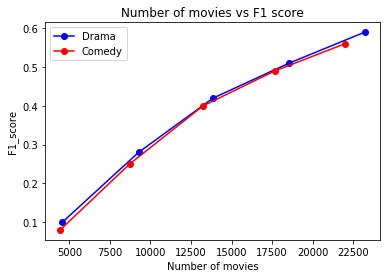

In [87]:
import matplotlib.pyplot as plt

plt.plot(df_drama_score.num_movies, df_drama_score.F1_score,  '-ok', color="blue");
plt.plot(df_comedy_score.num_movies, df_comedy_score.F1_score,  '-ok', color="red");
plt.legend(['Drama','Comedy'])
plt.xlabel('Number of movies') 
plt.ylabel('F1_score') 
plt.title('Number of movies vs F1 score')
plt.show()

We have shown that our second hypothesis is also true. 

Having more data is better to predict the results and looking at the graph it seems that it could continue increasing the score having more data, so lack of data can be the first cause for not having better results predicting genres out of the plot